# Histogram of Oriented Gradients
Authors: Thomas Schaper 10812350, Victor Gladys 10523626,

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
%matplotlib inline  

## Preprocessing
The image first had to be preprocessed. This was done using [GIMP](https://www.gimp.org/). The resulting image is shown below.

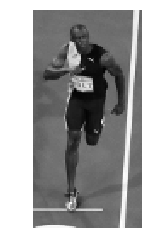

In [2]:
bolt = ndimage.imread("./bolt.png", mode='L')
plt.imshow(bolt, cmap='gray')
plt.axis('off')
plt.show()

## Calculate the Gradient Images
To calculate the gradient images we need the derivative of the original image. To get these we use, as specified, a gaussian filter. This is done by using the `gaussian_filter1d` function  of scipy. As we need the derivative in the x and y direction we use this function twice, selecting a different axis.

To get the gradient magnitude we use write a dedicate function, `cart2polar`, to calculate the gradient magnitude and angle. This is done by respectively using the following formula: $\sqrt{gx ^ 2 + gy ^ 2}$ and $arctan(\frac{gy}{gx})$.

The result of these different gradients can be seen in the plot below. In this plot we see the original, the derivative in the x direction, the  derivative in the y direction and the gradiet magnitute from left to right.

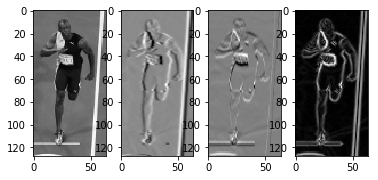

In [3]:
def cart2polar(fx, fy):
    return np.sqrt(fx**2 + fy**2), abs(np.arctan2(fy, fx))

gx = ndimage.filters.gaussian_filter1d(
    bolt.astype(float), 1, axis=1, order=1)
gy = ndimage.filters.gaussian_filter1d(
    bolt.astype(float), 1, axis=0, order=1)
plt.subplot(1, 4, 1)
plt.imshow(bolt, cmap='gray')
plt.subplot(1, 4, 2)
plt.imshow(gx, cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(gy, cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(cart2polar(gx, gy)[0], cmap='gray')
plt.show()

## Calculate HOG in 8x8 Cells
The histogram of the gradients is called the *HOG*. This is a histogram from 0
to $\pi$ where the value indicates the sum of the gradient magnitude for the
gradient angle at the given bin.

To calculate this HOG we first need a way to group the values. In the article
they group the values based on percentages. So if we have two bins of 10 and 20
and a value of 12 we assign 80% to the bin of 10 en 20 percent to the bin of 20.
To implement this we first find the bin which is less than or equal to the given
value. As each bin has a equal distance to the next bin we can also calculate
how much percent should go into the found bin, this is: $\frac{\text{value} -
\text{found bin}}{\text{bin delta}}$.

Now we calculate these two values for every pixel in our 8 x 8 block. Next we
use the `bincount` function of numpy with the closest bin as value and the
factor as weight to create a first version of our histogram. Next we increment
the bins modulo the amount of bins and set the weights to one minus the old
weights and bincount again. These two histograms are added together element by
element and the result is our histogram. The code to do this is shown below.

In [4]:
BIN_STARTS = list(np.linspace(0, np.pi, 10)[:-1])

def get_bin(angle):
    closest = 0
    for idx, bin_start in enumerate(BIN_STARTS):
        if angle >= bin_start:
            closest = idx
        else:
            break
    return closest, (angle - BIN_STARTS[closest]) / BIN_STARTS[1]


def HOG8x8(gx, gy):
    mag, angle = cart2polar(gx, gy)
    mag = mag.reshape(64)
    bins, percent = np.vectorize(get_bin)(np.mod(angle.reshape(64), np.pi / 2))
    res = np.bincount(bins, percent * mag, 9)
    bins = np.mod(bins + 1, 10)
    percent = 1 - percent
    res += np.bincount(bins, percent * mag, 9)
    return res

## Calculate the HOG feature vector
To create a HOG feature vector for the entire image we first calculate the x en
y derivatives as earlier but now for the entire image. After this we loop over
image with steps of 8 pixel in the x and y direction resulting in 7 and 15
blocks in respectively the x and y direction. For each pixel we create a block
of 16 x 16 pixel which we divide evenly into 4 smaller blocks of 8 x 8. For each
of these blocks we calculate the HOG, as explained above, and concatenate these
histograms.

Now we have a vector of 36 items. This vector is normalized by taking the norm
of this vector and dividing every element by this norm. The result is
concatenated together resulting in a vector of $7 * 15 * 36 = 3780$ items.

In [5]:
def HOGblock(h1, h2, h3, h4):
    block = np.concatenate((h1, h2, h3, h4))
    return block / np.linalg.norm(block)

def HOGall(bolt):
    y_blocks, x_blocks = (np.array(bolt.shape) / 8).astype(int) - 1
    gx = ndimage.filters.gaussian_filter1d(
        bolt.astype(float), 1, axis=1, order=1)
    gy = ndimage.filters.gaussian_filter1d(
        bolt.astype(float), 1, axis=0, order=1)
    res = np.array([])
    for y in range(y_blocks):
        for x in range(x_blocks):
            bgx = gx[y * 8:y * 8 + 16, x * 8:x * 8 + 16]
            bgy = gy[y * 8:y * 8 + 16, x * 8:x * 8 + 16]
            res = np.append(res,
                            HOGblock(
                                HOG8x8(bgx[0:8, 0:8], bgy[0:8, 0:8]),
                                HOG8x8(bgx[0:8, 8:16], bgy[0:8, 8:16]),
                                HOG8x8(bgx[8:16, 0:8], bgy[8:16, 0:8]),
                                HOG8x8(bgx[8:16, 8:16], bgy[8:16, 8:16])))
    return res

## Visualizing the HOG
To visualize this HOG vector of the entire image we need to reshape this vector
into something we can loop over or vectorize. As we concatenated $7 * 15 = 105$
blocks of 4 x 9 matrices together we reshape our HOG to a matrix of 105x4x9. We
loop over each 9x0 vector in this matrix and calculate the coordinates that it
corresponds to in the image. Now we can simply calculate a rose where the
direction is the gradient angle and the length is the magnitude.

As every coordinate can occur multiple times (one, two, three or four times) in
the HOG vector this results in a problem. There are multiple solutions to this
problem. One is to simply only take one histogram and ignore the rest, however
this does not seem right as it is arbitrary to decide which vector to keep and
which to ignore.

Another solution is to take the average of the vectors. This is also not ideal
as every vector is normalized using different blocks, however this seems the
best solution and therefore we adopted this solution. It is implemented by
simply keeping track of the sum of the magnitude and the amount of times every
block occurs. After this is done for every 8 x 8 pixel block we can calculate
the average magnitude and plot this value. This is implemented and visualized
below.

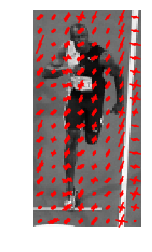

In [6]:
def get_middle(x, y):
    height = (y * 8) + 4
    width = (x * 8) + 4
    return (width, height)

def get_end(direction, factor):
    # negative y is taken because of the axis system of images
    delta_x1 =  (np.sin(direction) * 6 * factor)
    delta_y1 = -(np.cos(direction) * 6 * factor)
    direction = (direction + np.pi) % (2 * np.pi)
    delta_x2 =  (np.sin(direction) * 6 * factor)
    delta_y2 = -(np.cos(direction) * 6 * factor)
    return (delta_x1, delta_y1, delta_x2, delta_y2)

def coor_sum(first, second):
    new = list()
    for a, b in zip(first, second):
        new.append(a + b)
    return new


def plotHOG(bolt):
    plt.imshow(bolt, cmap='gray')
    hog = HOGall(bolt).reshape((7 * 15, 4, 9))
    seen = dict()
    max_val = np.amax(hog)
    for idx, block in enumerate(hog):
        for jdx, part in enumerate(block):
            x = (idx % 7) + (jdx % 2)
            y = (idx % 15) + max(0, min(1, jdx - 1))
            coor = (x, y)
            coor_new = list()
            for bin_num, _ in enumerate(BIN_STARTS):
                coor_new.append(part[bin_num] / max_val)
            if coor not in seen:
                seen[coor] = (0, [(0)] * len(coor_new))
            seen[coor] = (seen[coor][0] + 1, coor_sum(coor_new, seen[coor][1]))
    for (x, y), (amount, dxys) in seen.items():
        midx, midy = get_middle(x, y)
        for bin_num, factor_sum in enumerate(dxys):
            factor = factor_sum / amount
            dx1, dy1, dx2, dy2 = get_end(BIN_STARTS[bin_num], factor)
            plt.plot([midx, midx + dx1], [midy, midy + dy1], 'r')
            plt.plot([midx, midx + dx2], [midy, midy + dy2], 'r')
    plt.ylim([128, 0])
    plt.xlim([0, 64])
    plt.axis('off')
    plt.show()
    
plotHOG(bolt)